# 🤗 HuggingFace Demo

This demo demonstrates an end-to-end pipeline of HuggingFace transformer with MLRun.

The following example demonstrates how to package a project and how to run an automatic pipeline to train, evaluate, optimize and serve an HuggingFace model using MLRun functions.

1. [Register functions](#1.-Register-the-training-and-serving-functions)
2. [Set the workflow](#2.-Setting-the-workflow)
3. [Run the pipeline](#3.-Run-the-pipeline)
4. [Test the pipeline](#4.-Test-the-pipeline)
5. [gradio front-end](#5.-gradio-front-end)

The pipeline consists of the following steps:
1. **Dataset preparation** - Includes Loading data from the HuggingFace hub and applying tokenization (both train and test datasets).
2. **Train** - Loading a model from the hub, train and evaluation.
3. **Optimize** - Optimize the model with ONNX
4. **Serve** - Deploy a serving function with preprocess and postprocess functions.

In [1]:
import mlrun
import os

> 2022-10-27 14:05:38,684 [warning] Failed resolving version info. Ignoring and using defaults
> 2022-10-27 14:05:41,778 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '1.2.0-rc7', 'client_version': '0.0.0+unstable'}


## Creating a project

In [2]:
project = mlrun.get_or_create_project('huggingface', './', user_project=True)

> 2022-10-27 14:05:41,843 [info] loaded project huggingface from MLRun DB


## 1. Register the training functions
We'll use our training, evaluation and serving functions. To get them, we set them into the project using project.set_function and specify additional parameters such as the container image:

In [3]:
# Get our train functions:
project.set_function(
    "src/training_pipeline.py",
    name="training",
    kind="job",
    image="yonishelach/ml-models:huggingface-demo-3",
)

see the pipeline [functions](./src/training_pipeline.py)

In [4]:
# Get our ONNX serving function:
project.set_function(
    "src/onnx_model_server.py",
    name="serving", 
    kind="serving", 
    image="yonishelach/ml-models:huggingface-demo-3",
)

## 2. Setting the workflow

In order to take this project with the functions we set and the workflow we saved over to a different environemnt, first set the workflow to the project. The workflow can be set using `project.set_workflow`. After setting it, we will save the project by calling project.save. When loaded, it can be run from another environment from both code and from cli. For more information regarding saving and loading a MLRun project, see the documentation.

In [5]:
# Register the workflow file:
workflow_name = "sentiment_analysis_workflow"
project.set_workflow(workflow_name, "src/workflow.py")

# Save the project:
project.save()

## 3. Run the pipeline


We can immediately run the project, or save it to a git repository and load/run it on another cluster or CI/CD workflow. In order to load the project from a git you should run the following command (read more about projects and CI/CD):
```python
project = mlrun.load_project(context="./", url="git://github.com/<org>/<project>.git")
or use the CLI command:

mlrun project -u "git://github.com/mlrun/project-demo.git" ./
```
We will run the pipeline using project.run with the workflow name we used:

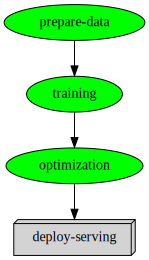

In [ ]:
workflow_run = project.run(
    name=workflow_name,
    arguments={
        "dataset_name": "Shayanvsf/US_Airline_Sentiment",
        "pretrained_tokenizer": "distilbert-base-uncased",
        "pretrained_model": "distilbert-base-uncased",
    },
    watch=True,
)

## 4. Test the pipeline

In [7]:
serving_function = project.get_function("serving")

In [8]:
serving_function.invoke(path='/predict', body='I love flying!')

> 2022-10-27 14:51:44,124 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-huggingface-yonatans-serving.default-tenant.svc.cluster.local:8080/predict'}


['The sentiment is POSITIVE', 'The prediction score is 2.63582181930542']

## 5. gradio front-end

Now we are taking the URL of the serving function and connecting it to the gradio code below

In [9]:
import gradio as gr
import requests

In [15]:
serving_url = f'http://{serving_function.status.address}'

In [16]:
def sentiment(text):
    resp = requests.post(serving_url, json={"text": text})
    return resp.json()


with gr.Blocks() as demo:
    input_box = [gr.Textbox(label="Text to analyze", placeholder="Please insert text")]
    output = [gr.Textbox(label="Sentiment analysis result"), gr.Textbox(label="Sentiment analysis score")]
    greet_btn = gr.Button("Submit")
    greet_btn.click(fn=sentiment, inputs=input_box, outputs=output)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://4a9ced1c19b3dcd3.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f8da33cbf90>,
 'http://127.0.0.1:7862/',
 'https://4a9ced1c19b3dcd3.gradio.app')